This notebook is split into 3 sections:
1. Introduction to LangGraph
2. Persistence
3. Memory

# Section 1: Intro to LangGraph

## Understanding LangChain Memory

Memory in LangChain refers to the ability of a language model application to retain and use information from previous interactions. This is crucial for:

- Maintaining coherent conversations
- Building context-aware applications
- Enabling personalized user experiences
- Supporting complex workflows that require state


In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Answer all questions to the best of your ability."),
    ("placeholder", "{messages}"),
])

model = ChatOpenAI()
chain = prompt | model

response = chain.invoke({
    "messages": [
        ("human", "Translate this sentence from English to French: I love programming."),
        ("ai", "J'adore programmer."),
        ("human", "What did you just say?"),
    ],
})

print(response.content)

I just said "J'adore programmer," which means "I love programming" in French.


## Memory and retrieval used to generate context-aware answers from an LLM
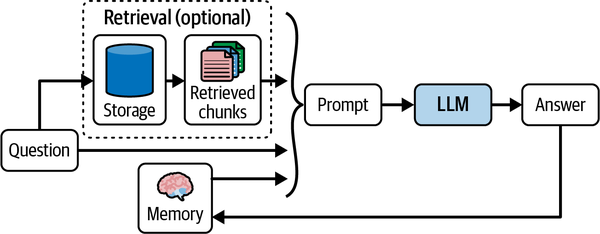

# LangGraph Overview

LangGraph — used by Replit, Uber, LinkedIn, GitLab and more — is a low-level orchestration framework for **building controllable agents**. While langchain provides integrations and composable components to streamline LLM application development, the LangGraph library enables agent orchestration — offering customizable architectures, long-term memory, and human-in-the-loop to reliably handle complex tasks.

LangGraph models agent workflows as graphs using three main components:

- **State**: A shared data structure representing the application's snapshot.
- **Nodes**: Functions that define agent behavior.
- **Edges**: Functions that determine which Node to execute next based on State.

These components work together to create complex workflows that evolve over time.

## Graph Algorithm

LangGraph uses message passing to define a general program. Nodes send messages to other nodes after completing their tasks, and the process proceeds in discrete "super-steps" where nodes may run in parallel or sequentially. The graph execution ends when all nodes are inactive and no messages are in transit.

## StateGraph Class

The `StateGraph` class represents the main graph and is parameterized by a user-defined State object. It provides methods to define the graph's structure, compile it, and run it.

## Compiling the Graph

Compiling a graph involves defining the State, adding Nodes and Edges, and ensuring the graph structure is valid. The `.compile()` method checks for issues like orphaned nodes and allows runtime configurations.

## State Definition

The State of the graph consists of the schema and reducer functions that apply updates to it. The schema is typically defined using a `TypedDict` or `Pydantic model`. Multiple schemas can be used for input, output, and internal communication within the graph.

## Reducers

Reducers define how updates from Nodes are applied to the State. A default reducer is used when no specific function is defined, but custom reducers (e.g., `operator.add`) can modify how state updates are merged.

## Working with Messages

Messages, like user input and LLM responses, can be tracked in the graph's state. The `add_messages` reducer function allows for appending and updating messages. LangGraph handles serialization/deserialization of messages to maintain consistency.

## MessagesState

`MessagesState` is a prebuilt state for managing messages in the graph. It includes a `messages` key for storing message objects and uses the `add_messages` reducer to handle updates.

## Nodes

Nodes in LangGraph are Python functions that take State as input and return an updated State. These functions can be synchronous or asynchronous, supporting configurable parameters through the `RunnableConfig` object.

## START and END Nodes

- The `START` node is the entry point for user input into the graph.
- The `END` node denotes the termination point.

These nodes are crucial for routing logic within workflows.

## Edges

Edges define how nodes communicate and how the graph progresses. Types of edges include:

- **Normal Edges**: Direct connections between nodes.
- **Conditional Edges**: Routing based on a function.
- **Entry Points**: Initial nodes for user input.
- **Conditional Entry Points**: Initial nodes determined by a function.

---

## Why use LangGraph?
LangGraph is built for developers who want to build powerful, adaptable AI agents. Developers choose LangGraph for:

- **Reliability and controllability**. Steer agent actions with moderation checks and human-in-the-loop approvals. LangGraph persists context for long-running workflows, keeping your agents on course.
- **Low-level and extensible**. Build custom agents with fully descriptive, low-level primitives – free from rigid abstractions that limit customization. Design scalable multi-agent systems, with each agent serving a specific role tailored to your use case.
- **First-class streaming support**. With token-by-token streaming and streaming of intermediate steps, LangGraph gives users clear visibility into agent reasoning and actions as they unfold in real time.

---

## Pipeline Visualization

### From single-actor to multiactor applications 

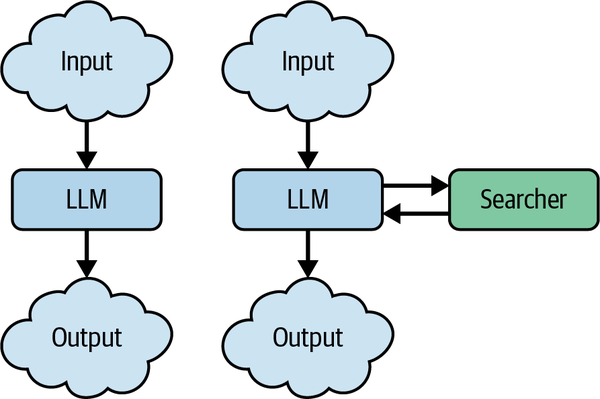

### From multiactor to multistep

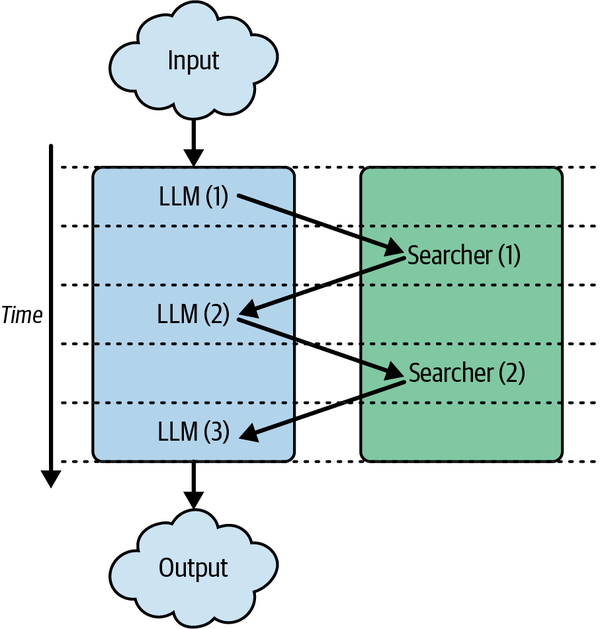

### From multistep to stateful applications

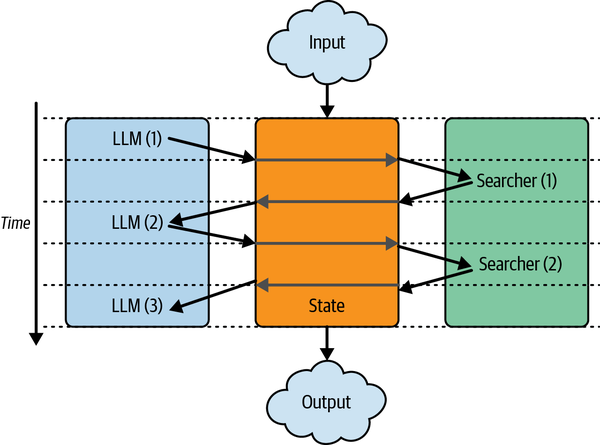

## Building a Chatbot Memory System
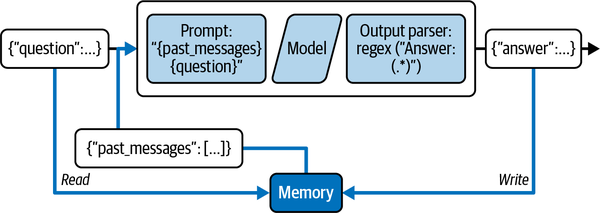

**Key aspects:**
- Simple to implement
- Uses a placeholder mechanism to pass previous messages
- Requires manual tracking of conversation state
- Limited built-in support for complex state management

# Creating a StateGraph
### LangGraph Implementation

### Part 1: Build a Basic Chatbot
We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

class State(TypedDict):
    messages: Annotated[list, add_messages]

builder = StateGraph(State)

Our graph can now handle two key tasks:

1. Each `node` can receive the current `State` as input and output an update to the state.
2. Updates to `messages` will be appended to the existing list rather than overwriting it, thanks to the prebuilt `add_messages` function used with the `Annotated` syntax.

### 🔥 Concept
When defining a graph, the first step is to define its `State`. The `State` includes the graph's schema and reducer functions that handle state updates. In our example, `State` is a `TypedDict` with one key: `messages`. The `add_messages` reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values. Learn more about state, reducers, and related concepts [in this guide](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages).

Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [3]:
model = ChatOpenAI()

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [4]:
builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [5]:
builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [6]:
# Add persistence with MemorySaver
graph = builder.compile(checkpointer=MemorySaver())

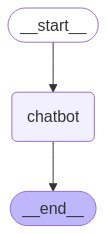

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot!

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [8]:
# Configure thread
thread1 = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, thread1):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  q


Goodbye!


# Section 2: Persistence

LangGraph features a built-in persistence layer using checkpointers, which save the graph's state at each super-step. These checkpoints are stored in a thread, allowing access to the graph's state after execution. This enables capabilities like human-in-the-loop, memory, time travel, and fault tolerance. A guide is available for using checkpointers with your graph.

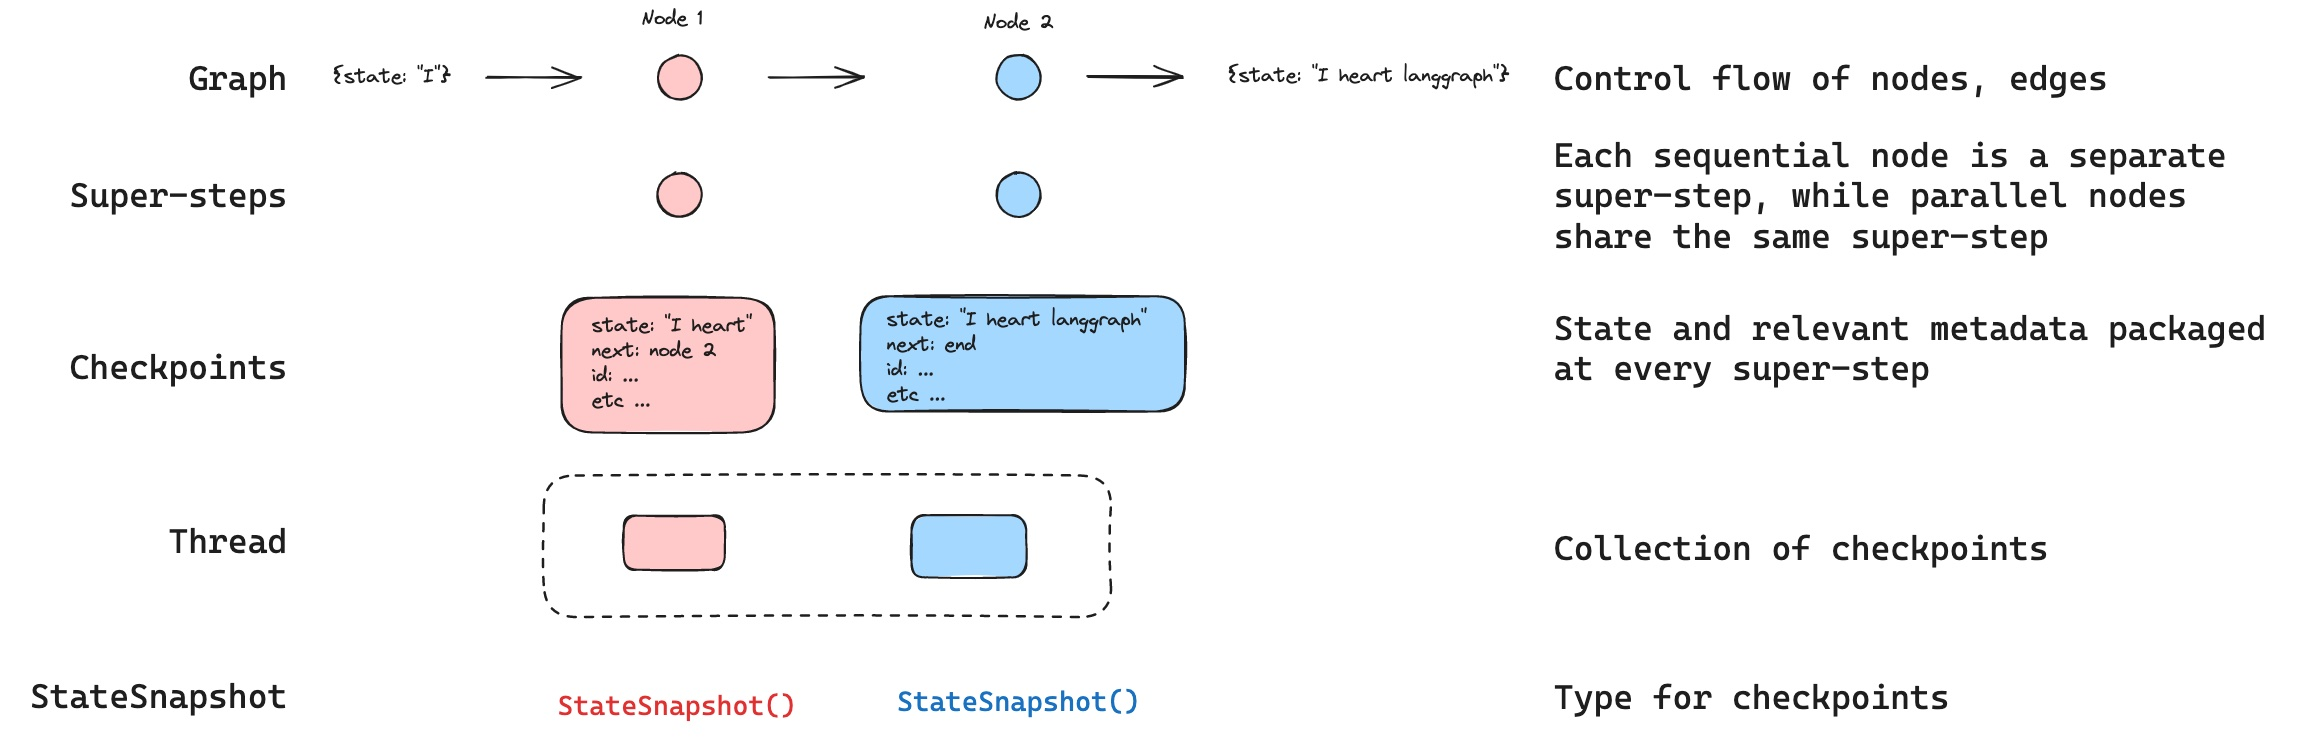

## Threads
A thread is a unique identifier assigned to each checkpoint saved by a checkpointer in LangGraph. When using a checkpointer, you must specify a thread_id in the configuration.

``` python
{"configurable": {"thread_id": "1"}}
```

### Checkpoints
A checkpoint is a snapshot of the graph state at each super-step, represented by a `StateSnapshot` object with key properties including:

- **config**: The configuration associated with the checkpoint.

- **metadata**: Metadata related to the checkpoint.

- **values**: State channel values at that time.

- **next**: Node names to execute next.

- **tasks**: Information about the next tasks, including errors or interrupts if applicable.

In [9]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    # Log output after node_a executes
    print("Node A executed, state:", state)
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    # Log output after node_b executes
    print("Node B executed, state:", state)
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}

# Instead of directly invoking, use the graph's invoke method and print intermediate states.
def stream_result(input_state: dict, config: dict):
    print("Starting workflow with initial state:", input_state)
    result = graph.invoke(input_state, config)
    print("Final result:", result)

stream_result({"foo": ""}, config)


Starting workflow with initial state: {'foo': ''}
Node A executed, state: {'foo': '', 'bar': []}
Node B executed, state: {'foo': 'a', 'bar': ['a']}
Final result: {'foo': 'b', 'bar': ['a', 'b']}


### Get State
To interact with the saved graph state, you must specify a thread identifier. You can view the latest state by calling `graph.get_state(config)`, which returns a `StateSnapshot` object corresponding to the latest checkpoint for the specified thread ID or checkpoint ID.

In our example, the output of `get_state` will look like this:

In [10]:
# get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f014b76-6067-6704-8002-955bad770229'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'thread_id': '1', 'step': 2, 'parents': {}}, created_at='2025-04-08T20:23:57.175578+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f014b76-6064-6dea-8001-6e121a260350'}}, tasks=())

### Get state history
You can retrieve the full history of a graph execution for a given thread by calling `graph.get_state_history(config)`. This returns a list of `StateSnapshot` objects for the specified thread ID, ordered chronologically with the most recent checkpoint first.

In our example, the output of `get_state_history` will look like this:

In [11]:
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f014b76-6067-6704-8002-955bad770229'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'thread_id': '1', 'step': 2, 'parents': {}}, created_at='2025-04-08T20:23:57.175578+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f014b76-6064-6dea-8001-6e121a260350'}}, tasks=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f014b76-6064-6dea-8001-6e121a260350'}}, metadata={'source': 'loop', 'writes': {'node_a': {'foo': 'a', 'bar': ['a']}}, 'thread_id': '1', 'step': 1, 'parents': {}}, created_at='2025-04-08T20:23:57.174525+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f014b76-6062-60de-8000-167b8d5b6b1b'}}, tasks=(Preg

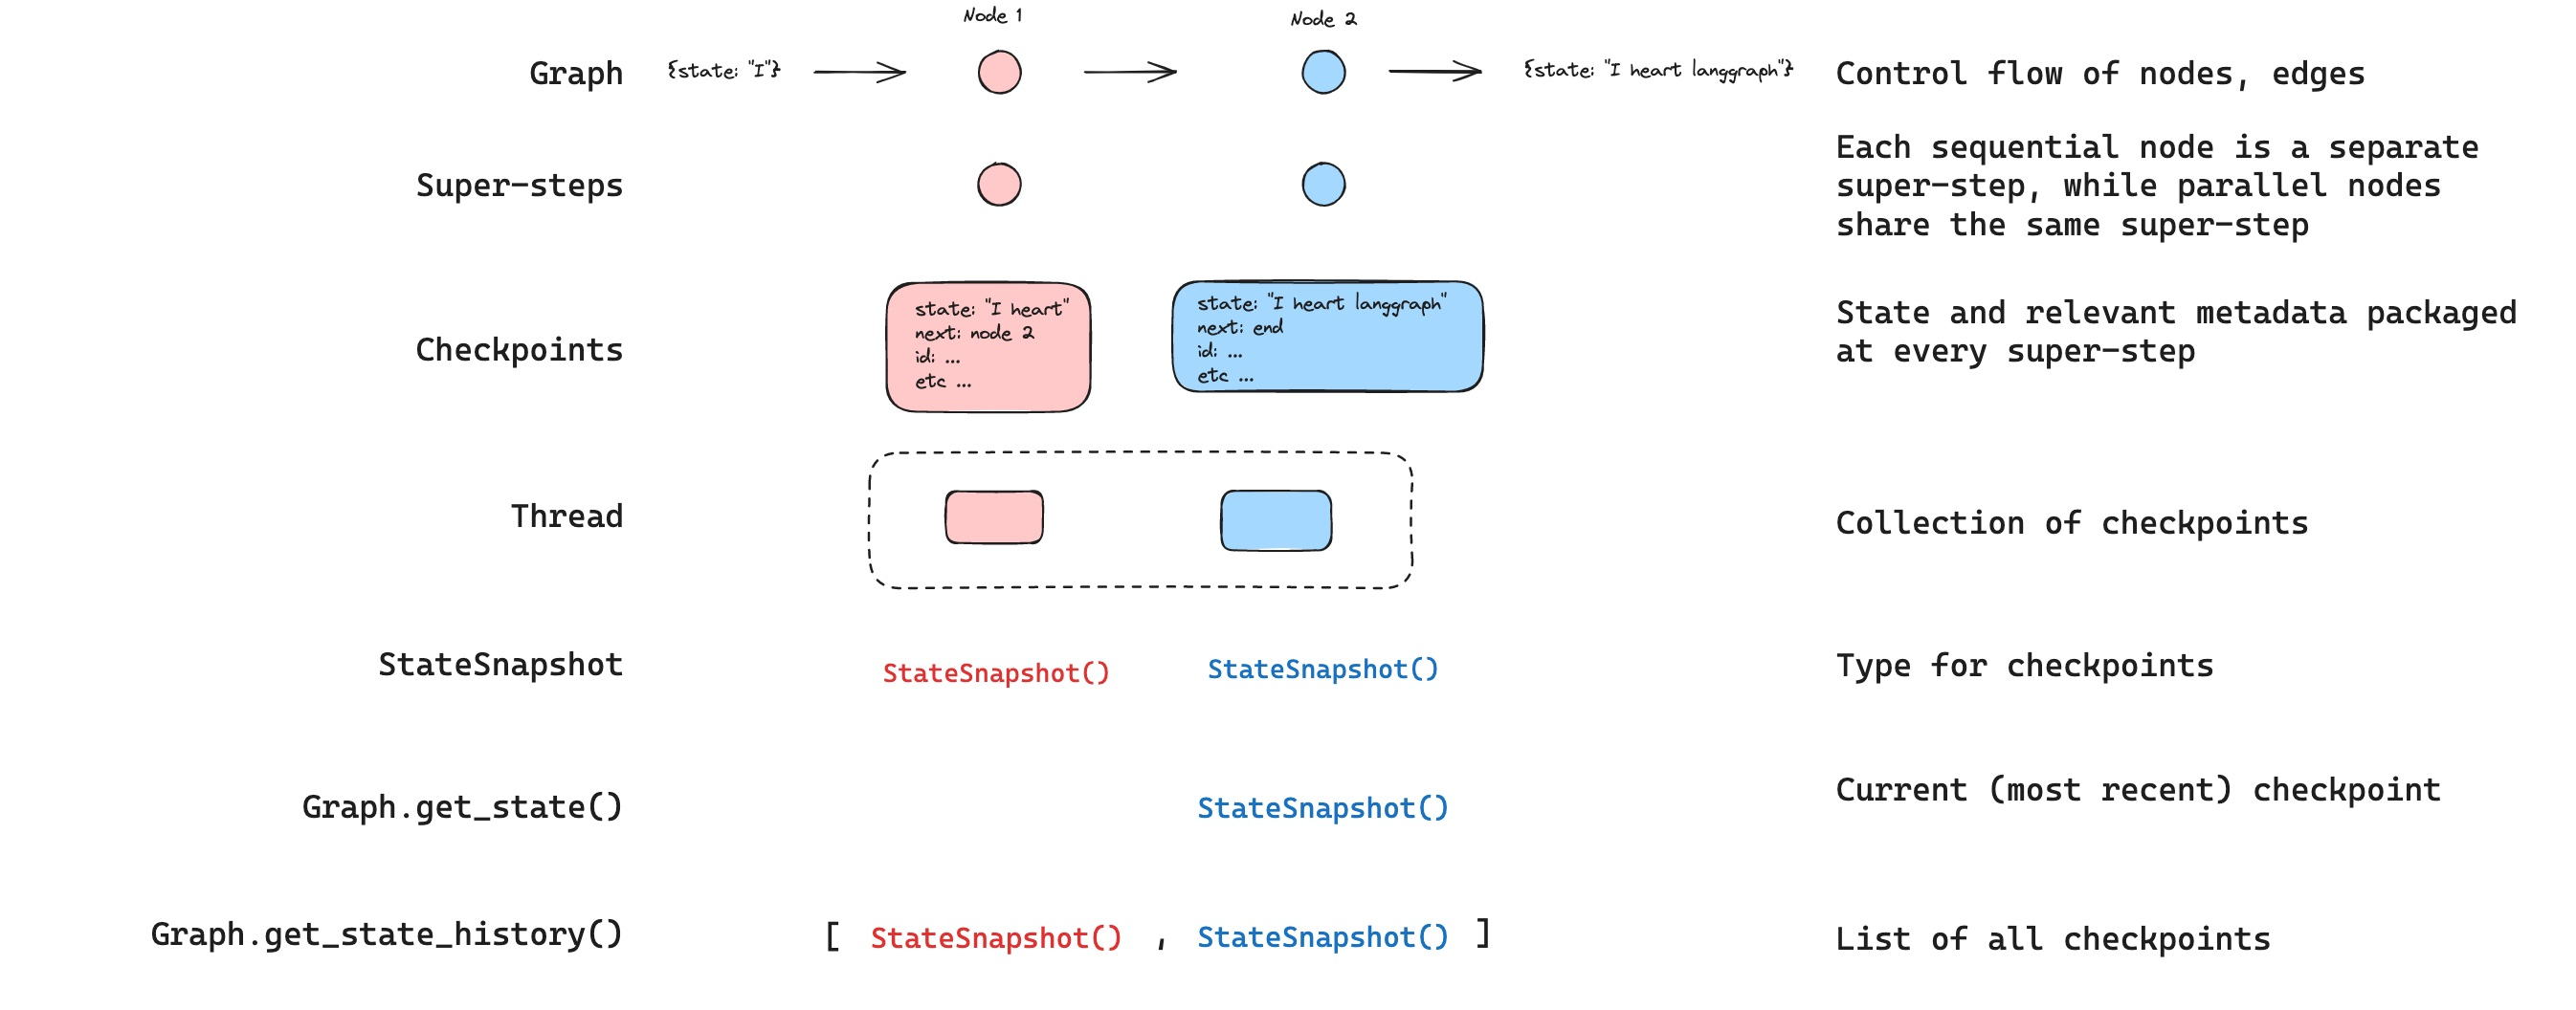

### Replay
You can replay a prior graph execution by providing a `thread_id` and a `checkpoint_id`. This will re-execute the steps before the specified checkpoint and only execute the steps after it. Both identifiers must be passed in the configuration when invoking the graph.

You must pass these when invoking the graph as part of the configurable portion of the config:
``` python
config = {"configurable": {"thread_id": "1", "checkpoint_id": "00000000000000000000000000000000"}}
graph.invoke(None, config=config)
```

LangGraph tracks whether a step has been executed before. If a step has already been executed, it will only replay that step up to the provided `checkpoint_id`, without re-executing it. However, steps after the `checkpoint_id` will always be executed, even if they were previously run.

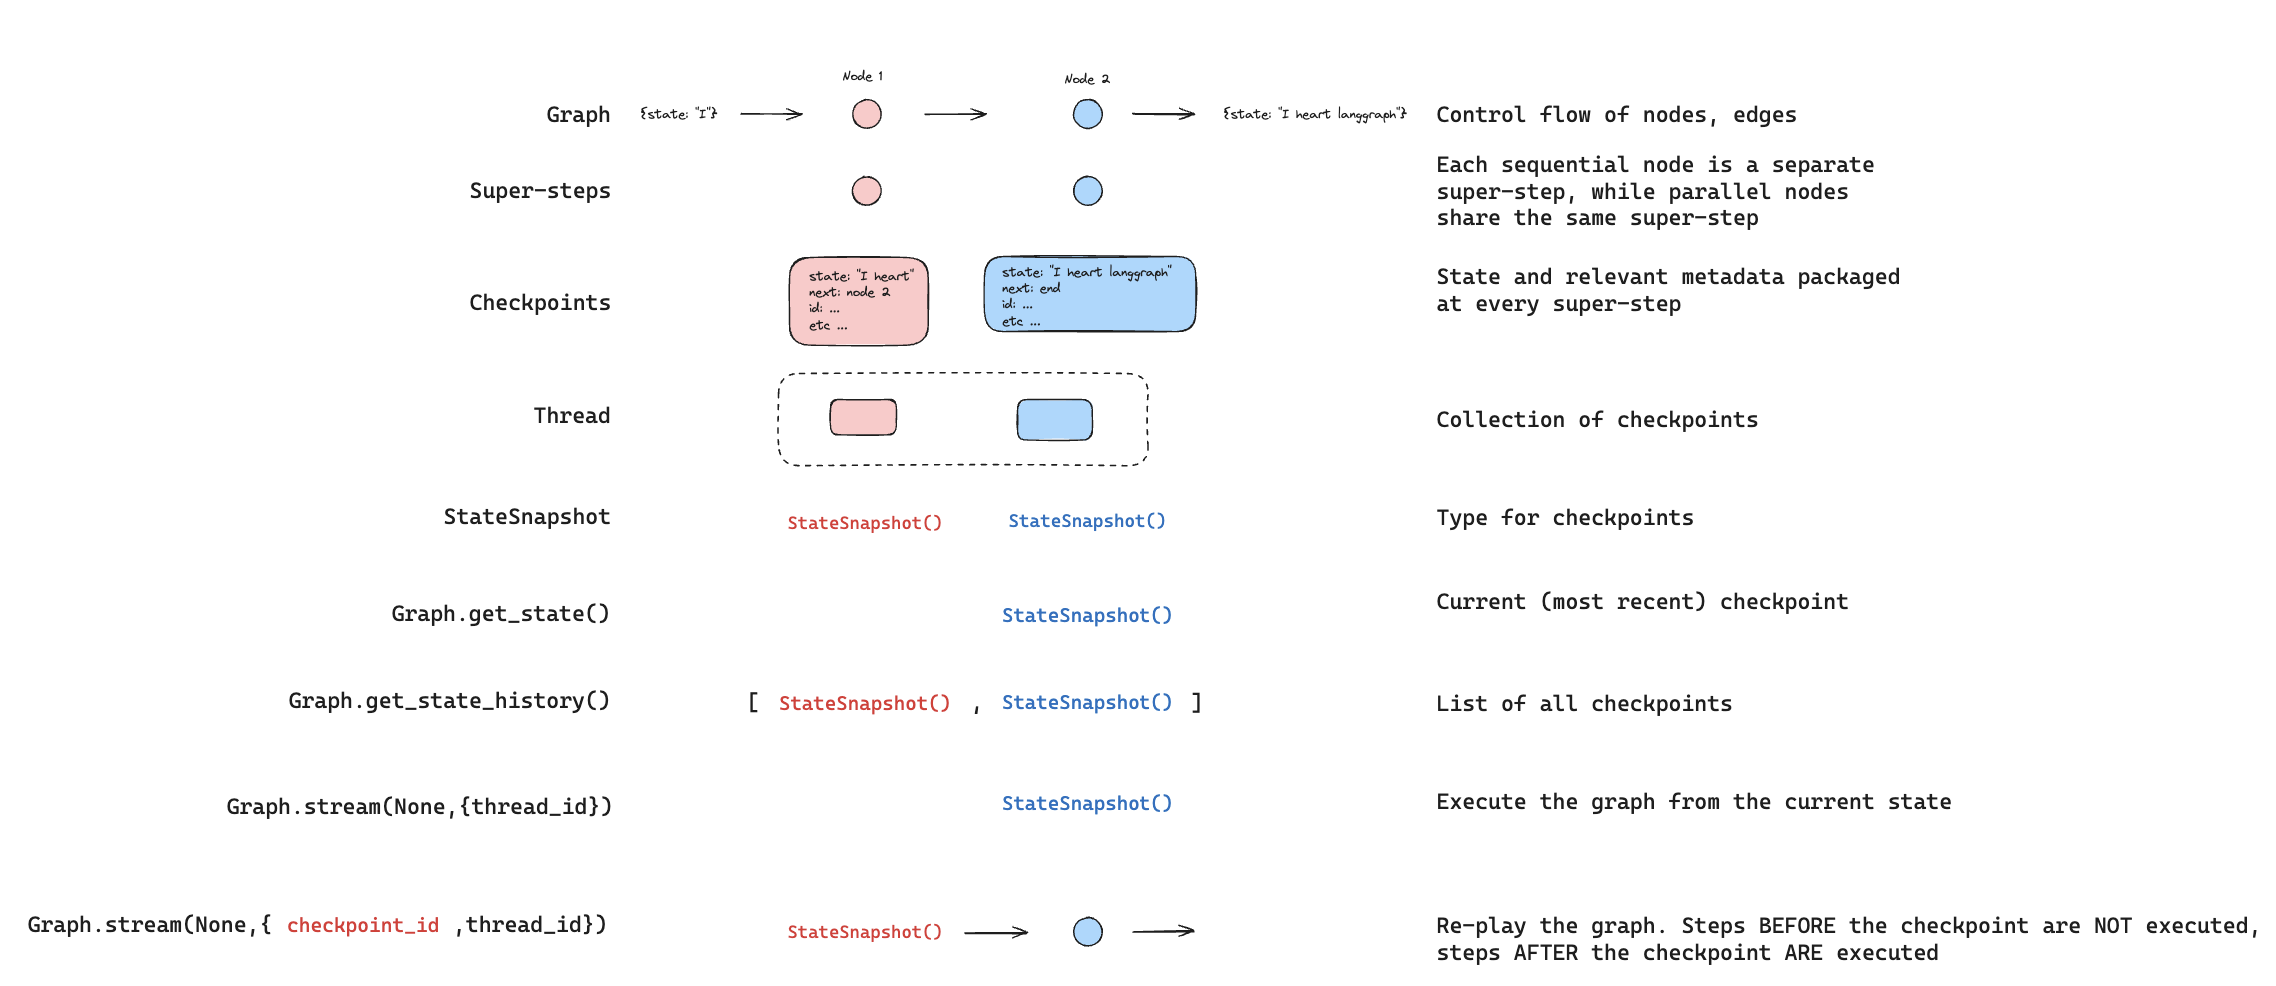

### Update state
LangGraph allows you to edit the graph state using `graph.update_state()`. This method accepts three arguments:

1. **config**: Specifies the thread_id`` to update the thread state. Optionally, you can include a `checkpoint_id` to fork from a specific checkpoint.

2. **values**: The values used to update the state, which are passed to the reducer functions for any channels that define them. The update does not automatically overwrite all channel values, only those without reducers.

Let's assume you have defined the state of your graph with the following schema (example above):
``` python
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: int
    bar: Annotated[list[str], add]
```
Let's now assume the current state of the graph is
``` python
{"foo": 1, "bar": ["a"]}
```
If you update the state as below:
``` python
graph.update_state(config, {"foo": 2, "bar": ["b"]})
```
Then the new state of the graph will be:
``` python
{"foo": 2, "bar": ["a", "b"]}
```
When calling `update_state()`, if a channel (e.g., "foo") has no reducer, it is completely overwritten. However, if a channel (e.g., "bar") has a reducer, the update appends to the existing state. Additionally, you can specify `as_node` to control which node is considered as the source of the state update, influencing the next node to execute. If not provided, `as_node` defaults to the last node that updated the state.

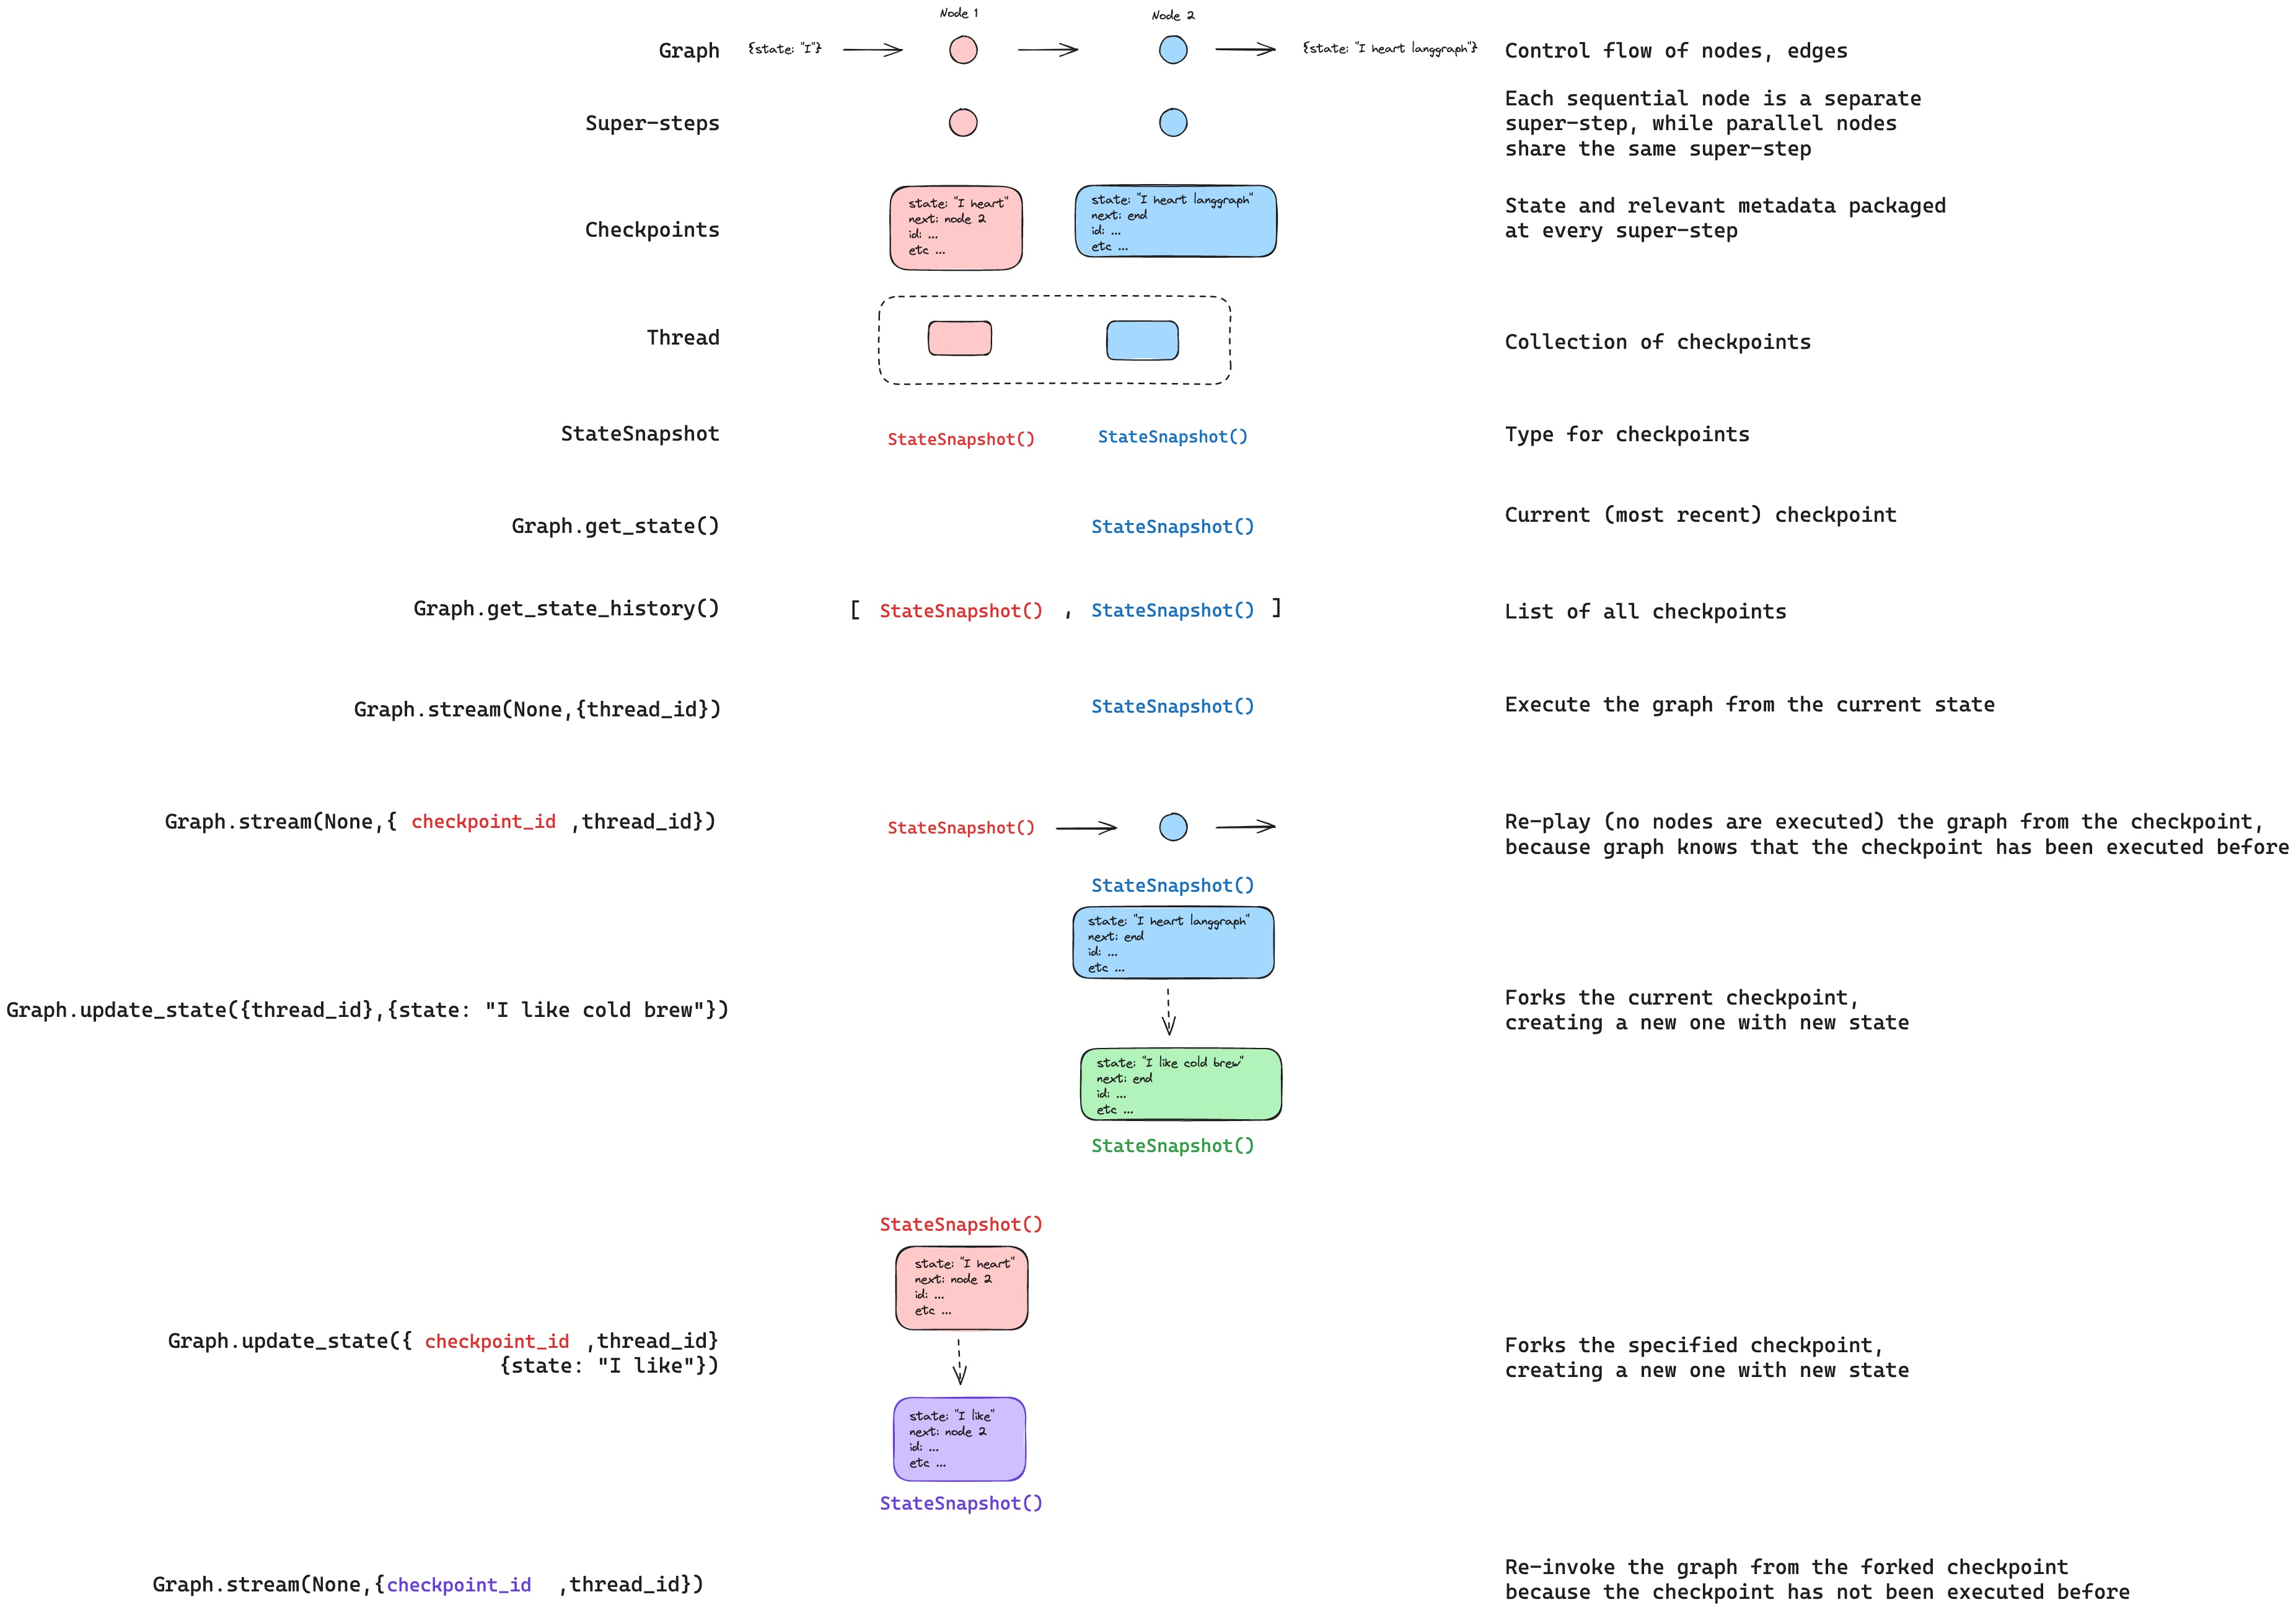


### Memory Store

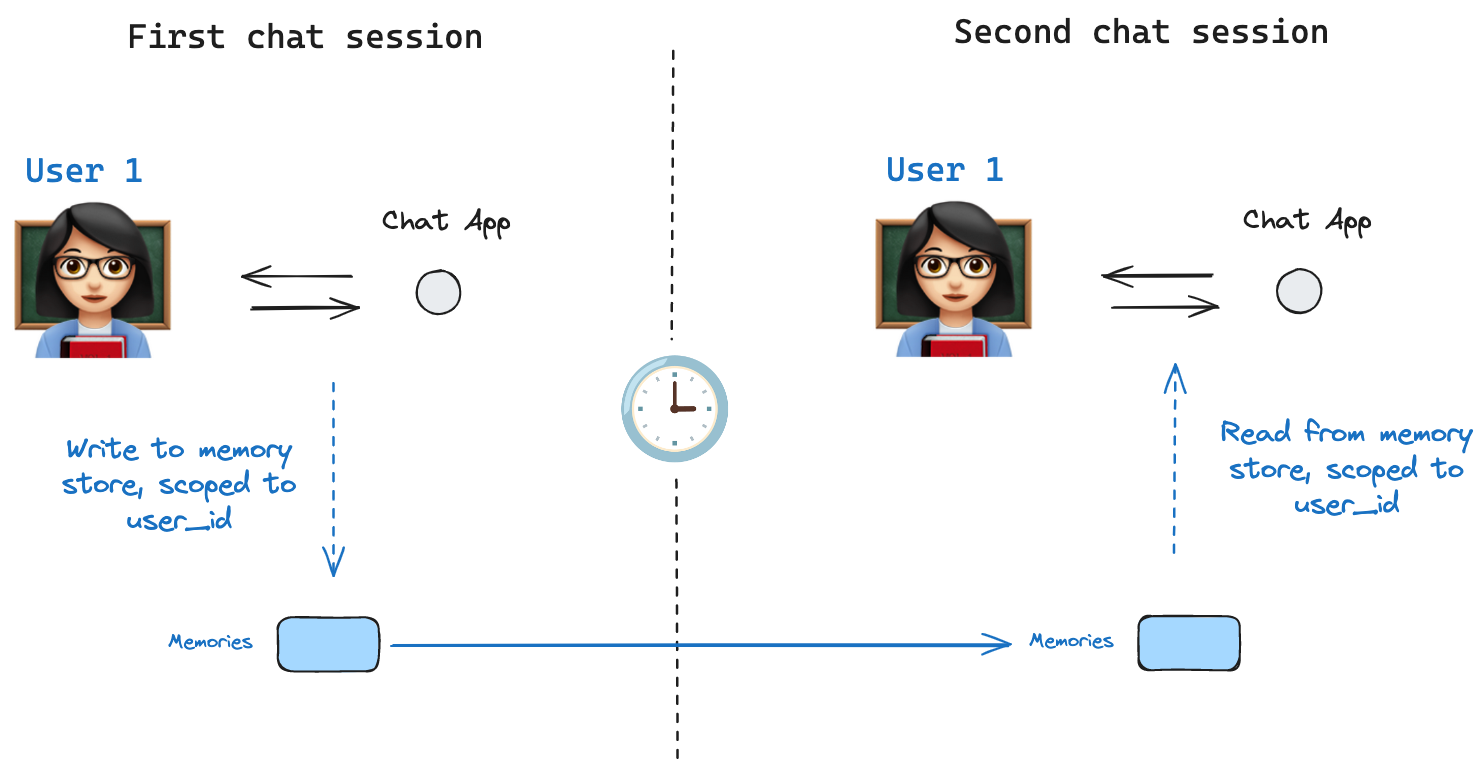

A state schema defines keys that are populated during graph execution, allowing state persistence via checkpointers. However, checkpointers can't share information across threads, which is needed in cases like retaining user-specific data across chatbot conversations. To achieve this, LangGraph uses the Store interface. For example, an `InMemoryStore` can be used to store user data across threads, alongside checkpointers, ensuring persistence across different interactions. LangGraph automatically handles stores.

### Basic Usage
First, let's showcase this in isolation without using LangGraph.

In [12]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

Memories are namespaced by a `tuple`, which in this specific example will be `(<user_id>, "memories")`. The namespace can be any length and represent anything, does not have to be user specific.

In [13]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

We use the `store.put` method to save memories to our namespace in the store. When we do this, we specify the namespace, as defined above, and a key-value pair for the memory: the key is simply a unique identifier for the memory `(memory_id)` and the value (a dictionary) is the memory itself.

In [14]:
import uuid
memory_id = str(uuid.uuid4())
memory = {"food_preference" : "I like pizza"}
in_memory_store.put(namespace_for_memory, memory_id, memory)

We can read out memories in our namespace using the `store.search` method, which will return all memories for a given user as a list. The most recent memory is the last in the list.

In [15]:
memories = in_memory_store.search(namespace_for_memory)
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': '73e63941-d484-4686-bce9-a473e0225cca',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-04-08T20:23:57.238782+00:00',
 'updated_at': '2025-04-08T20:23:57.238782+00:00',
 'score': None}

Each memory type is a Python class ('Item') with certain attributes. We can access it as a dictionary by converting via `.dict` as above. The attributes it has are:

- **value**: The value (itself a dictionary) of this memory
- **key**: A unique key for this memory in this namespace
- **namespace**: A list of strings, the namespace of this memory type
- **created_at**: Timestamp for when this memory was created
- **updated_at**: Timestamp for when this memory was updated

### Semantic Search
The store supports semantic search, allowing memories to be retrieved based on meaning rather than exact matches. This can be enabled by configuring the store with an embedding model.

``` python
from langchain.embeddings import init_embeddings

store = InMemoryStore(
    index={
        "embed": init_embeddings("openai:text-embedding-3-small"),  # Embedding provider
        "dims": 1536,                              # Embedding dimensions
        "fields": ["food_preference", "$"]              # Fields to embed
    }
)
```
**Now when searching, you can use natural language queries to find relevant memories:**
``` python
# Find memories about food preferences
# (This can be done after putting memories into the store)
memories = store.search(
    namespace_for_memory,
    query="What does the user like to eat?",
    limit=3  # Return top 3 matches
)

### Using in LangGraph
The `in_memory_store` in LangGraph works with the checkpointer to store arbitrary information across threads. The checkpointer saves state to threads, while the `in_memory_store` allows access to this information across different threads. Both are used together when compiling the graph.
``` python
from langgraph.checkpoint.memory import InMemorySaver

# We need this because we want to enable threads (conversations)
checkpointer = InMemorySaver()

# ... Define the graph ...

# Compile the graph with the checkpointer and store
graph = graph.compile(checkpointer=checkpointer, store=in_memory_store)
```
We invoke the graph with a `thread_id`, as before, and also with a `user_id`, which we'll use to namespace our memories to this particular user as we showed above.
``` python
# Invoke the graph
user_id = "1"
config = {"configurable": {"thread_id": "1", "user_id": user_id}}

# First let's just say hi to the AI
for update in graph.stream(
    {"messages": [{"role": "user", "content": "hi"}]}, config, stream_mode="updates"
):
    print(update)
```
We can access the `in_memory_store` and the `user_id` in any node by passing `store: BaseStore` and `config: RunnableConfig` as node arguments. Here's how we might use semantic search in a node to find relevant memories:
``` python
def update_memory(state: MessagesState, config: RunnableConfig, *, store: BaseStore):

    # Get the user id from the config
    user_id = config["configurable"]["user_id"]

    # Namespace the memory
    namespace = (user_id, "memories")

    # ... Analyze conversation and create a new memory

    # Create a new memory ID
    memory_id = str(uuid.uuid4())

    # We create a new memory
    store.put(namespace, memory_id, {"memory": memory})
```
As we showed above, we can also access the store in any node and use the `store.search` method to get memories. Recall the the memories are returned as a list of objects that can be converted to a dictionary.
``` python
memories[-1].dict()
{'value': {'food_preference': 'I like pizza'},
 'key': '07e0caf4-1631-47b7-b15f-65515d4c1843',
 'namespace': ['1', 'memories'],
 'created_at': '2024-10-02T17:22:31.590602+00:00',
 'updated_at': '2024-10-02T17:22:31.590605+00:00'}
 ```
We can access the memories and use them in our model call.
``` python
def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # Get the user id from the config
    user_id = config["configurable"]["user_id"]

    # Namespace the memory
    namespace = (user_id, "memories")

    # Search based on the most recent message
    memories = store.search(
        namespace,
        query=state["messages"][-1].content,
        limit=3
    )
    info = "\n".join([d.value["memory"] for d in memories])

    # ... Use memories in the model call
```
If we create a new thread, we can still access the same memories so long as the `user_id` is the same.
``` python
# Invoke the graph
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# Let's say hi again
for update in graph.stream(
    {"messages": [{"role": "user", "content": "hi, tell me about my memories"}]}, config, stream_mode="updates"
):
    print(update)
```

### Checkpointer libraries
LangGraph provides various checkpointer implementations for saving graph state, including:

1. **langgraph-checkpoint**: The base checkpointer interface with an in-memory implementation for experimentation.

2. **langgraph-checkpoint-sqlite**: A SQLite-based checkpointer, ideal for local workflows.

3. **langgraph-checkpoint-postgres**: A Postgres-based checkpointer used in LangGraph Cloud, ideal for production.

### Checkpointer interface
The **Checkpointer interface** in LangGraph includes the following methods:

1. **.put**: Stores a checkpoint with its configuration and metadata.

2. **.put_writes**: Stores intermediate writes linked to a checkpoint.

3. **.get_tuple**: Retrieves a checkpoint tuple using thread and checkpoint IDs to populate the graph state.

4. **.list**: Lists checkpoints matching specific configurations and filters, used for state history.

For asynchronous graph execution, the interface provides asynchronous versions of these methods (e.g., `.aput`, `.aput_writes`, `.aget_tuple`, `.alist`).

### Serializer
The **Serializer** in LangGraph is used by checkpointers to serialize channel values when saving the graph state. LangGraph provides a default implementation, **JsonPlusSerializer**, which handles various types, including LangChain and LangGraph primitives, datetimes, enums, and more.

### Capabilities
**Human-in-the-loop**: Checkpointers enable human-in-the-loop workflows, allowing humans to inspect, interrupt, and approve graph steps. This ensures the ability to view and resume the graph's state at any point.

**Memory:** Checkpointers support "memory" between interactions, making it possible to retain information from previous interactions, such as in conversations, and maintain context for follow-up messages.

**Time Travel**: Checkpointers allow "time travel," enabling the replay of prior graph executions and the ability to debug or review specific steps. They also facilitate forking the graph state to explore different outcomes.

**Fault-tolerance**: Checkpoints provide fault tolerance by allowing graph execution to restart from the last successful step in case of failures. LangGraph stores pending writes from successful nodes to prevent re-execution of completed nodes.

**Pending Writes**: When a node fails, LangGraph saves pending writes from other successfully completed nodes, ensuring that successful nodes are not re-executed when the graph resumes.

# Section 3: Memory

## What is Memory?

Memory helps both humans and AI agents retain and use information efficiently. Just like working with someone who forgets everything is frustrating, AI agents also need memory to adapt and provide a better user experience.

There are two types of memory:

- **Short-term memory**, or thread-scoped memory: Available within a single conversation. Managed by LangGraph using a “state” that’s saved with a checkpointer for continuity.

- **Long-term memory**: Shared across all conversations. It’s stored and recalled using custom namespaces and LangGraph’s memory stores.

Both types allow AI agents to learn from past interactions and personalize their responses.

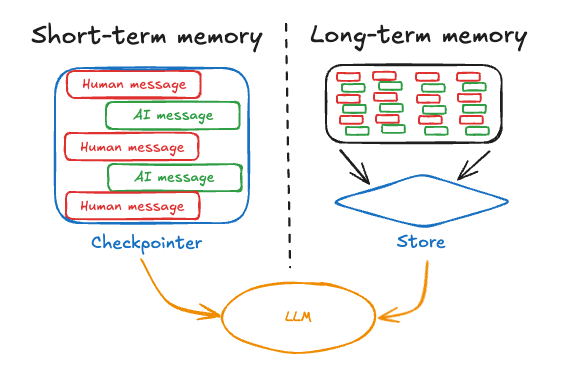

## Short-term memory

Short-term memory allows an app to remember interactions within a single conversation thread, like how emails are grouped. LangGraph manages this memory using checkpoints that save conversation history and other data (like files or documents) as part of the agent’s state.

However, long conversations can overwhelm language models due to context window limits, reducing accuracy and increasing cost. To manage this, developers often:

- **Edit message lists** to trim irrelevant or outdated content.

- **Summarize past messages** to retain context while reducing token count.

Managing short-term memory is about balancing detail with performance (speed and cost).

### Editing message lists

Chat models use a growing list of messages—system instructions and user inputs—for context. As this list expands, it can exceed context limits and increase costs.

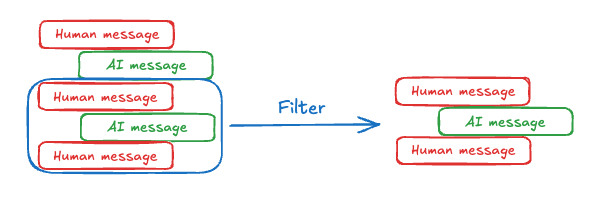

To manage this, developers often delete old messages, like in a least-recently-used cache. In LangGraph, this is typically done by having a node return an update that tells the system which parts of the message list to keep.

```python
from typing import Union, Annotated, TypedDict

def manage_list(existing: list, updates: Union[list, dict]):
    if isinstance(updates, list):
        # Normal case, add to the history
        return existing + updates
    elif isinstance(updates, dict) and updates["type"] == "keep":
        # You get to decide what this looks like.
        # For example, you could simplify and just accept a string "DELETE"
        # and clear the entire list.
        return existing[updates["from"]:updates["to"]]
    # etc. We define how to interpret updates

class State(TypedDict):
    my_list: Annotated[list, manage_list]

def my_node(state: State):
    return {
        # We return an update for the field "my_list" saying to
        # keep only values from index -5 to the end (deleting the rest)
        "my_list": {"type": "keep", "from": -5, "to": None}
    }
```


LangGraph uses a **reducer function** like `manage_list` to handle updates to message lists. When an update is returned under the key `"my_list"`, the reducer defines how to process it.

You can:

- **Add messages** to grow the conversation.

- **Keep specific parts** of the state using a dictionary.

- **Remove messages by ID** using "remove" objects (e.g., `RemoveMessage` in LangChain).

This gives you control to drop old context and manage memory efficiently.

``` python
from langchain_core.messages import RemoveMessage, AIMessage
from langgraph.graph import add_messages
# Other imports...

class State(TypedDict):
    # add_messages will default to upserting messages by ID to the existing list
    # if a RemoveMessage is returned, it will delete the message in the list by ID
    messages: Annotated[list, add_messages]

def my_node_1(state: State):
    # Add an AI message to the `messages` list in the state
    return {"messages": [AIMessage(content="Hi")]}

def my_node_2(state: State):
    # Delete all but the last 2 messages from the `messages` list in the state
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    return {"messages": delete_messages}

```

In the example above, the `add_messages` reducer allows us to append new messages to the `messages` state key as shown in `my_node_1`. When it sees a `RemoveMessage`, it will delete the message with that ID from the list (and the RemoveMessage will then be discarded).

### Summarizing past conversations
Trimming or deleting messages can cause important information to be lost. To avoid this, some applications use **summarization**—a more advanced method that condenses message history using a chat model while preserving key context.

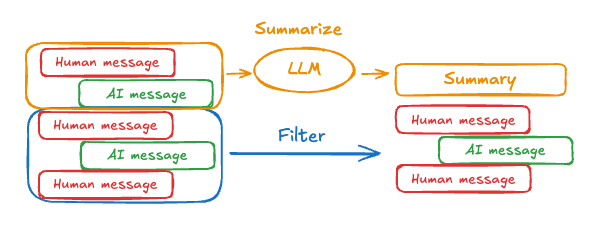

Simple prompting and orchestration logic can be used to achieve this. As an example, in LangGraph we can extend the MessagesState to include a `summary` key.

``` python 
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str
```

Then, we can generate a summary of the chat history, using any existing summary as context for the next summary. This `summarize_conversation` node can be called after some number of messages have accumulated in the `messages` state key.

``` python
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is a summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}
```

### Build the chatbot
**1. Let's now build the chatbot graph.**

In [16]:
from typing import Literal

from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END

memory = MemorySaver()


# We will add a `summary` attribute (in addition to `messages` key,
# which MessagesState already has)
class State(MessagesState):
    summary: str


# We will use this model for both the conversation and the summarization
model = ChatOpenAI()

**2. Define the logic to call the model**

In [17]:
def call_model(state: State):
    # If a summary exists, we add this in as a system message
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We now define the logic for determining whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """Return the next node to execute."""
    messages = state["messages"]
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    # Otherwise we can just end
    return END


def summarize_conversation(state: State):
    # First, we summarize the conversation
    summary = state.get("summary", "")
    if summary:
        # If a summary already exists, we use a different system prompt
        # to summarize it than if one didn't
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # We now need to delete messages that we no longer want to show up
    # I will delete all but the last two messages, but you can change this
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

**3. Define a new graph and nodes**

In [18]:
workflow = StateGraph(State)

# Define the conversation node and the summarize node
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `conversation`.
    # This means these are the edges taken after the `conversation` node is called.
    "conversation",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `summarize_conversation` to END.
# This means that after `summarize_conversation` is called, we end.
workflow.add_edge("summarize_conversation", END)

# Finally, we compile it!
app = workflow.compile(checkpointer=memory)

### Using the graph

In [19]:
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

In [20]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4"}}

input_message = HumanMessage(content="hi! I'm jake")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="what's my name?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="i like the yankees!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

hi! I'm jake
================================== Ai Message ==================================

Hello, Jake! How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Jake. How can I assist you today, Jake?
================================ Human Message =================================

i like the yankees!
================================== Ai Message ==================================

That's great to hear, Jake! The New York Yankees are a very popular baseball team with a rich history. Do you have a favorite player or memorable game that you'd like to talk about?


**We can see that so far no summarization has happened - this is because there are only six messages in the list.**

In [21]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content="hi! I'm jake", additional_kwargs={}, response_metadata={}, id='fbec5473-ae02-4c31-8aa8-41bf390f2457'),
  AIMessage(content='Hello, Jake! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 13, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-144913df-d9f9-48f1-ab1f-72588600aecd-0', usage_metadata={'input_tokens': 13, 'output_tokens': 12, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='83bcf228-42d0-40b9-

**Now let's send another message in**

In [22]:
input_message = HumanMessage(content="i like how much they win")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

i like how much they win
================================== Ai Message ==================================

The New York Yankees have a long history of success and have won many championships over the years. It's always exciting to support a winning team! Are you looking forward to the upcoming season and hoping for more victories from the Yankees?
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


In the conversation above, Jake introduced himself as a fan of the New

**If we check the state now, we can see that we have a summary of the conversation, as well as the last two messages**

In [23]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='i like how much they win', additional_kwargs={}, response_metadata={}, id='ee3425a5-1c50-4b40-91c2-7aa4f56cf5b5'),
  AIMessage(content="The New York Yankees have a long history of success and have won many championships over the years. It's always exciting to support a winning team! Are you looking forward to the upcoming season and hoping for more victories from the Yankees?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 119, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b78ba1ef-aaab-4e81-a3dd-9c05b6d015fe-0', usage_metadata={'input_tokens': 119, 'output_tokens': 47, 'total_tokens': 166, '

**We can now resume having a conversation! Note that even though we only have the last two messages, we can still ask it questions about things mentioned earlier in the conversation (because we summarized those)**

In [24]:
input_message = HumanMessage(content="what's my name?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Jake.


In [25]:
input_message = HumanMessage(content="what NFL team do you think I like?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

what NFL team do you think I like?
================================== Ai Message ==================================

Based on our previous conversation where you mentioned being a fan of the New York Yankees, it's possible that you could be a fan of the New York Giants or the New York Jets since they are the NFL teams based in New York. Do you have a preference between these two teams or do you support another NFL team?


In [26]:
input_message = HumanMessage(content="i like the colts!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

i like the colts!
================================== Ai Message ==================================

That's great! The Indianapolis Colts have a storied history and have had some impressive seasons. Do you have a favorite player on the Colts or any memorable games that stand out to you? It's always exciting to support a team that you're passionate about!
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


In the continuation of the conversation, it was revealed that Ja

## Knowing when to remove messages
LLMs have a token limit for their context window. A simple way to manage this is by **counting tokens** in the message history and **truncating** when nearing the limit.

While easy to implement, watch out for message order rules in some APIs (e.g., must start with a human message). If using LangChain, the `trim_messages` utility helps by letting you set a token limit and choose a strategy (like keeping the last few messages)

``` python
from langchain_core.messages import trim_messages
trim_messages(
    messages,
    # Keep the last <= n_count tokens of the messages.
    strategy="last",
    # Remember to adjust based on your model
    # or else pass a custom token_encoder
    token_counter=ChatOpenAI(model="gpt-4"),
    # Remember to adjust based on the desired conversation
    # length
    max_tokens=45,
    # Most chat models expect that chat history starts with either:
    # (1) a HumanMessage or
    # (2) a SystemMessage followed by a HumanMessage
    start_on="human",
    # Most chat models expect that chat history ends with either:
    # (1) a HumanMessage or
    # (2) a ToolMessage
    end_on=("human", "tool"),
    # Usually, we want to keep the SystemMessage
    # if it's present in the original history.
    # The SystemMessage has special instructions for the model.
    include_system=True,
)
```

# Long-term memory
Long-term memory in LangGraph allows systems to retain information across multiple conversations by storing it in **custom namespaces**. Unlike short-term memory, which is thread-specific, long-term memory is saved as **JSON documents** under these namespaces.

Each memory has a unique key and can be organized hierarchically (e.g., by user or organization IDs). LangGraph also supports **cross-namespace searching** using content filters.

``` python
from langgraph.store.memory import InMemoryStore


def embed(texts: list[str]) -> list[list[float]]:
    # Replace with an actual embedding function or LangChain embeddings object
    return [[1.0, 2.0] * len(texts)]


# InMemoryStore saves data to an in-memory dictionary. Use a DB-backed store in production use.
store = InMemoryStore(index={"embed": embed, "dims": 2})
user_id = "my-user"
application_context = "chitchat"
namespace = (user_id, application_context)
store.put(
    namespace,
    "a-memory",
    {
        "rules": [
            "User likes short, direct language",
            "User only speaks English & python",
        ],
        "my-key": "my-value",
    },
)
# get the "memory" by ID
item = store.get(namespace, "a-memory")
# search for "memories" within this namespace, filtering on content equivalence, sorted by vector similarity
items = store.search(
    namespace, filter={"my-key": "my-value"}, query="language preferences"
)
```

### Framework for thinking about long-term memory
Long-term memory is complex, with no one-size-fits-all solution. To navigate it, consider these key questions:

- **What type of memory is needed?** Like humans, AI agents can remember facts, experiences, or rules to complete tasks.

- **When should memories be updated?** Memory can be updated either during the agent’s logic process (before responding) or as a background task (asynchronously). Both methods have tradeoffs.


Different applications need different types of memory, and studying human memory can offer insights into how AI memory types work.

### Memory types
Different applications require various types of memory. Although the analogy isn't perfect, examining **[human memory types](https://www.psychologytoday.com/us/basics/memory/types-of-memory?ref=blog.langchain.dev)** can be insightful. Some research (e.g., **[the CoALA paper](https://arxiv.org/pdf/2309.02427)**) have even mapped these human memory types to those used in AI agents.

| Memory Type  | What is Stored   | Human Example                | Agent Example            |
|--------------|------------------|------------------------------|--------------------------|
| Semantic     | Facts            | Things I learned in school   | Facts about a user       |
| Episodic     | Experiences      | Things I did                 | Past agent actions       |
| Procedural   | Instructions     | Instincts or motor skills    | Agent system prompt      |


**Semantic memory** involves storing specific facts and concepts, both for humans (e.g., school knowledge) and AI agents (e.g., user facts from past interactions). It’s important to differentiate **semantic memory** (storing knowledge) from **semantic search** (retrieving information based on meaning).

For managing semantic memory, AI agents often use a **profile**—a continuously updated JSON document that contains key information about a user or entity. As the profile grows, it may need to be split into multiple documents or carefully managed to prevent errors in updating and maintaining the memory schema.

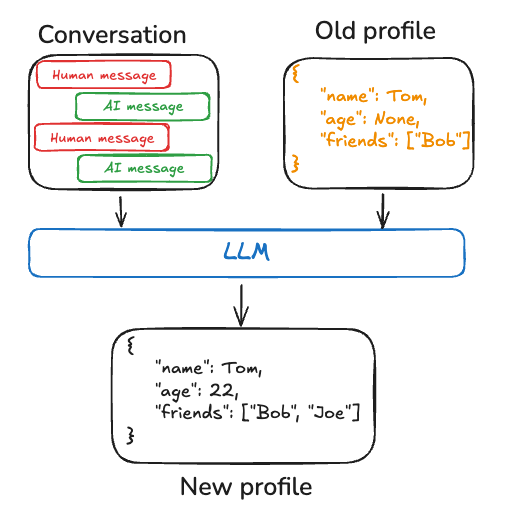

**Document collections** offer an alternative to profiles for storing memories. Each memory is a separate, narrowly scoped document, making it easier to generate new information without losing data. This approach leads to better recall but introduces challenges in updating and deleting items in the collection.

While document collections allow for **semantic search** and content filtering, they can make providing complete context difficult, as individual documents may not capture relationships between memories. This can result in less comprehensive context compared to a unified profile approach.

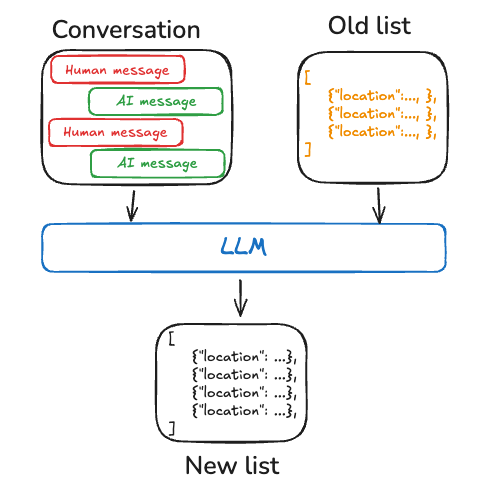

Regardless of memory management approach, **the central point is that the agent will use the semantic memories to create its responses**, which often leads to more personalized and relevant interactions.

**Episodic memory** involves recalling past events or actions. For AI agents, it helps them remember how to accomplish tasks by learning from previous experiences. This is often done through **few-shot learning**, where past input-output examples are used to guide the agent's behavior.

Few-shot learning lets LLMs be "programmed" by updating prompts with examples, making it easier to demonstrate desired behavior. Tools like LangSmith Datasets can store these examples, and dynamic selectors can retrieve the most relevant ones based on user input, using algorithms like BM25 for keyword similarity.


**Procedural memory** involves remembering how to perform tasks, like riding a bike in humans. For AI agents, it consists of model weights, agent code, and prompts that define the agent's functionality. While agents rarely modify their model weights or code, they often update their prompts.

A useful technique for improving an agent’s performance is **[Reflection](https://blog.langchain.dev/reflection-agents/) or meta-prompting**, where the agent adjusts its instructions based on feedback or prior interactions. This allows the agent to adapt and refine its behavior over time, especially when tasks are hard to define upfront. An example is a Tweet generator that improves summaries through user feedback and prompt rewrites.

The below pseudo-code shows how you might implement this with the LangGraph memory store, using the store to save a prompt, the `update_instructions` node to get the current prompt (as well as feedback from the conversation with the user captured in `state["messages"]`), update the prompt, and save the new prompt back to the store. Then, the `call_model` get the updated prompt from the store and uses it to generate a response.

``` python
# Node that *uses* the instructions
def call_model(state: State, store: BaseStore):
    namespace = ("agent_instructions", )
    instructions = store.get(namespace, key="agent_a")[0]
    # Application logic
    prompt = prompt_template.format(instructions=instructions.value["instructions"])
    ...

# Node that updates instructions
def update_instructions(state: State, store: BaseStore):
    namespace = ("instructions",)
    current_instructions = store.search(namespace)[0]
    # Memory logic
    prompt = prompt_template.format(instructions=instructions.value["instructions"], conversation=state["messages"])
    output = llm.invoke(prompt)
    new_instructions = output['new_instructions']
    store.put(("agent_instructions",), "agent_a", {"instructions": new_instructions})
    ...
```

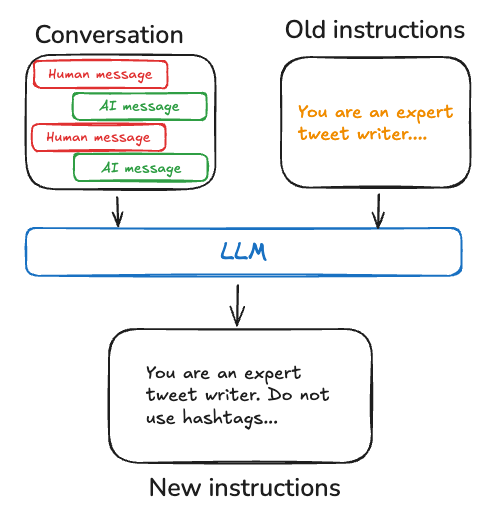

## Writing Memories
AI agents can write memories in two primary ways: "**on the hot path**" (immediately, during active interactions) and "**in the background**" (asynchronous, during less active periods). These approaches differ in timing and context, depending on when the memory needs to be created.

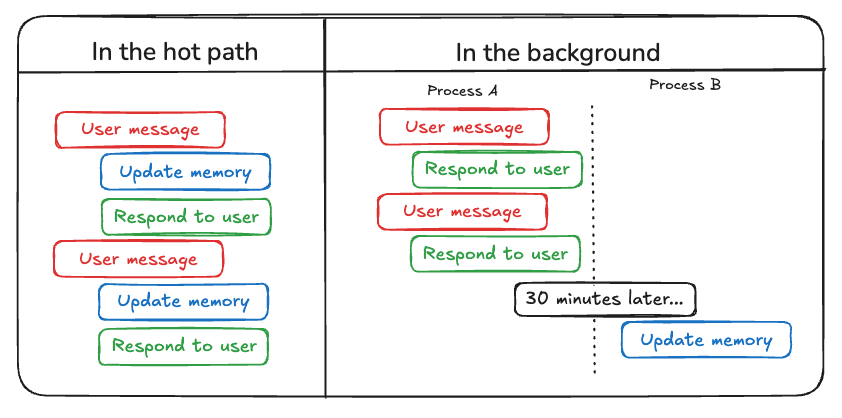

### Writing Memories in the hot path
Creating memories "on the hot path" allows real-time updates, making memories immediately available for future interactions, and offering transparency to users. However, it adds complexity, as the agent must decide what to save, which can impact latency and multitask management. This approach may affect the quality and quantity of memories created, as seen in ChatGPT’s use of a "save_memories" tool for updating memories during interactions.

### Writing memories in the background
Creating memories as a background task reduces latency, separates application logic from memory management, and allows for more focused task completion. It also provides flexibility in timing memory creation. However, it presents challenges in determining how often to update memories and when to trigger memory formation. Common strategies include scheduling updates at set intervals, using cron schedules, or allowing manual triggers.

# BONUS

## Industry Use Case: Customer Insight Extraction

### Problem Statement

A financial services company receives thousands of customer support chat logs daily. Data scientists need to extract actionable insights from these conversations to improve products and services.

### Solution Architecture

In [27]:
import os
import json
import pandas as pd
from typing import Annotated, TypedDict, List, Dict, Any
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages

# Define state structures
class ConversationInsights(TypedDict):
    customer_sentiment: str
    primary_issues: List[str]
    product_mentions: List[str]
    action_items: List[str]
    priority_level: str

class State(TypedDict):
    messages: Annotated[list, add_messages]
    conversation_id: str
    insights: ConversationInsights
    metadata: Dict[str, Any]
    processing_complete: bool

# Initialize components
model = ChatOpenAI(model="gpt-4") 

In [28]:
# System prompts
ANALYZER_PROMPT = """
You are an expert financial services analyst. Review the customer support conversation and extract the following insights:
1. Overall customer sentiment (positive, neutral, negative)
2. Primary issues or pain points mentioned
3. Financial products referenced in the conversation
4. Action items needed based on the conversation
5. Priority level (low, medium, high, critical)

Format your response as a structured JSON object with the fields:
{
  "customer_sentiment": "value",
  "primary_issues": ["issue1", "issue2"],
  "product_mentions": ["product1", "product2"],
  "action_items": ["action1", "action2"],
  "priority_level": "value"
}
"""

# Define workflow functions
def initialize_state(conversation_data):
    """Prepare the initial state with conversation data"""
    messages = []
    
    # Add conversation history from dataset
    for turn in conversation_data["turns"]:
        if turn["role"] == "customer":
            messages.append(HumanMessage(content=turn["message"]))
        else:
            messages.append(AIMessage(content=turn["message"]))
            
    # Add metadata
    metadata = {
        "customer_id": conversation_data.get("customer_id", "unknown"),
        "timestamp": conversation_data.get("timestamp", "unknown"),
        "channel": conversation_data.get("channel", "chat"),
    }
    
    return {
        "messages": messages,
        "conversation_id": conversation_data["conversation_id"],
        "insights": {
            "customer_sentiment": "",
            "primary_issues": [],
            "product_mentions": [],
            "action_items": [],
            "priority_level": "",
        },
        "metadata": metadata,
        "processing_complete": False
    }

def analyze_conversation(state: State):
    """Extract insights from the conversation"""
    # Create analyzer message
    analyzer_message = SystemMessage(content=ANALYZER_PROMPT)
    
    # Combine all messages for analysis
    all_messages = [analyzer_message] + state["messages"]
    
    # Get analysis from model
    analysis_result = model.invoke(all_messages)
    
    # Parse response (in practice, add error handling here)
    try:
        insights = json.loads(analysis_result.content)
    except:
        # Fallback for malformed JSON
        insights = {
            "customer_sentiment": "unknown",
            "primary_issues": ["parsing_error"],
            "product_mentions": [],
            "action_items": ["review_manually"],
            "priority_level": "medium"
        }
    
    # Update state
    return {
        "insights": insights,
        "processing_complete": True
    }

def should_end(state: State):
    """Determine if processing is complete"""
    if state["processing_complete"]:
        return "end"
    else:
        return "analyze"

# Build the graph
builder = StateGraph(State)
builder.add_node("analyze", analyze_conversation)
builder.add_conditional_edges(START, should_end)
builder.add_edge("analyze", END)

# Compile the graph without a checkpointer
graph = builder.compile()


In [29]:
# Generate sample data
def generate_sample_data(num_conversations=3):
    """Generate sample conversation data for demonstration purposes"""
    sample_conversations = []
    
    conversation_templates = [
        {
            "conversation_id": "conv-001",
            "customer_id": "cust-123",
            "timestamp": "2025-04-01T10:15:00",
            "channel": "chat",
            "turns": [
                {"role": "customer", "message": "Hi, I've been having trouble with my savings account. The interest rate seems lower than advertised."},
                {"role": "agent", "message": "I'm sorry to hear that. Let me check your account details. Can you confirm when you opened the account?"},
                {"role": "customer", "message": "I opened it about 3 months ago. The promotional material said 3.5% APY, but I'm only getting 2.1%."},
                {"role": "agent", "message": "I see the issue. The 3.5% rate requires a minimum balance of $10,000, and it looks like your balance has been below that threshold."},
                {"role": "customer", "message": "That wasn't clear in the promotional material. I feel misled about this."},
                {"role": "agent", "message": "I understand your frustration. Let me check if we can make an exception in your case given the confusion."},
                {"role": "customer", "message": "Thank you, I'd appreciate that. I was planning to open a CD account as well, but now I'm hesitant."},
                {"role": "agent", "message": "I've submitted a request to review your case. In the meantime, would you like information about our current CD rates? We have a special promotion running."},
                {"role": "customer", "message": "Maybe later. For now, I just want my savings account issue resolved."}
            ]
        },
        {
            "conversation_id": "conv-002",
            "customer_id": "cust-456",
            "timestamp": "2025-04-01T11:30:00",
            "channel": "chat",
            "turns": [
                {"role": "customer", "message": "Hello! I just got approved for my mortgage loan. Thanks for making the process so smooth!"},
                {"role": "agent", "message": "That's wonderful news! Congratulations on your mortgage approval. Is there anything else I can help you with today?"},
                {"role": "customer", "message": "Yes, I was wondering about setting up autopay for the mortgage payments."},
                {"role": "agent", "message": "I'd be happy to help with that. Autopay can be set up through your online banking portal or I can walk you through it now."},
                {"role": "customer", "message": "Let's do it now if possible. Also, do you have any recommendations for home insurance providers?"},
                {"role": "agent", "message": "Certainly! Let's set up the autopay first, then I can share some information about our partner insurance providers who offer discounts to our mortgage customers."}
            ]
        },
        {
            "conversation_id": "conv-003",
            "customer_id": "cust-789",
            "timestamp": "2025-04-01T14:45:00",
            "channel": "chat",
            "turns": [
                {"role": "customer", "message": "I'm trying to use the mobile app to transfer money but keep getting an error code E-445. What's going on?"},
                {"role": "agent", "message": "I apologize for the inconvenience. Error E-445 typically relates to a temporary system issue. When did you first notice this problem?"},
                {"role": "customer", "message": "It started about an hour ago. I need to make this transfer urgently to pay my rent."},
                {"role": "agent", "message": "I understand the urgency. Let me check the system status... It appears we're having some technical difficulties with the transfer function. Our team is working on it."},
                {"role": "customer", "message": "This is very frustrating. How long will it take to fix? My rent is due today."},
                {"role": "agent", "message": "I completely understand your concern. While the system is being fixed, I can help you make this transfer manually through our secure chat. Would that work for you?"},
                {"role": "customer", "message": "Yes please, that would be helpful."},
                {"role": "agent", "message": "Great. I'll need to verify your identity first, then we can proceed with the transfer."}
            ]
        }
    ]
    
    # Use the templates directly or customize as needed
    for i in range(min(num_conversations, len(conversation_templates))):
        sample_conversations.append(conversation_templates[i])
    
    return pd.DataFrame(sample_conversations)

# Process the sample conversations
def process_conversation_batch(conversations_df):
    """Process a batch of conversations"""
    results = []
    
    for _, row in conversations_df.iterrows():
        conversation_data = row.to_dict()
        
        # Initialize the state with this conversation
        initial_state = initialize_state(conversation_data)
        
        # Process the conversation
        final_state = graph.invoke(initial_state)
        
        # Add to results
        results.append({
            "conversation_id": final_state["conversation_id"],
            "insights": final_state["insights"],
            "metadata": final_state["metadata"]
        })
    
    return results

# Running the example
def run_example():
    """Run the complete example with sample data"""
    print("Generating sample conversation data...")
    sample_conversations_df = generate_sample_data(3)
    
    print(f"Processing {len(sample_conversations_df)} conversations...")
    results = process_conversation_batch(sample_conversations_df)
    
    print("\nAnalysis Results:")
    for result in results:
        print(f"\nConversation ID: {result['conversation_id']}")
        print(f"Customer ID: {result['metadata']['customer_id']}")
        print(f"Sentiment: {result['insights']['customer_sentiment']}")
        print(f"Issues: {', '.join(result['insights']['primary_issues'])}")
        print(f"Products: {', '.join(result['insights']['product_mentions'])}")
        print(f"Priority: {result['insights']['priority_level']}")
        print(f"Actions: {', '.join(result['insights']['action_items'])}")
        print("-" * 50)
    
    return results


In [30]:
# Example call
analysis_results = run_example()

Generating sample conversation data...
Processing 3 conversations...

Analysis Results:

Conversation ID: conv-001
Customer ID: cust-123
Sentiment: negative
Issues: misleading promotional material, incorrect interest rate
Products: savings account, CD account
Priority: high
Actions: review customer's case for exception, resolve savings account issue
--------------------------------------------------

Conversation ID: conv-002
Customer ID: cust-456
Sentiment: positive
Issues: Setting up autopay for mortgage payments, Inquiry about home insurance providers
Products: Mortgage loan, Home insurance
Priority: medium
Actions: Assist with autopay setup, Recommend home insurance providers
--------------------------------------------------

Conversation ID: conv-003
Customer ID: cust-789
Sentiment: negative
Issues: technical difficulties with mobile app, urgent need to transfer funds
Products: mobile banking app, money transfer
Priority: high
Actions: verify customer identity, assist with manual